
# Predicción de precios de casas con PyTorch (King County)

**Fecha de generación:** 2025-10-21 18:19

Este notebook cumple con los criterios del ejercicio:
- **Preparación y preprocesamiento** (carga, limpieza, división 65/20/15)
- **Normalización de características** (excepto `price`)
- **Modelo Feed-Forward en PyTorch** (>=2 capas ocultas, ReLU, MSE, Adam con `weight_decay`)
- **Entrenamiento y validación** (100 épocas + gráfica de pérdidas)
- **Evaluación en test** (pérdida final)


In [2]:

# =========================
# 1) Imports y configuración
# =========================
import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from typing import List

# Reproducibilidad
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cpu')


## 1. Preparación de los datos

- Carga del `dataset.csv` (ruta **absoluta**).
- Limpieza básica: quitar espacios en nombres de columnas, eliminación de nulos en columnas clave.
- Verificación de consistencia.


In [5]:

# Ruta ABSOLUTA al CSV (ajusta si lo ejecutas en otro entorno)
# En este entorno, el archivo subido está en /mnt/data/dataset.csv
DATA_PATH = "dataset.csv"  # Cambia a '/workspace/dataset.csv' si es tu ruta


df = pd.read_csv(DATA_PATH)

# Limpia nombres de columnas
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

print("Dimensiones iniciales:", df.shape)
print("Columnas:", df.columns.tolist())

# Visualiza primeras filas
df.head()


Dimensiones iniciales: (21613, 21)
Columnas: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:

# Columnas clave típicas del dataset de King County
# (ajusta esta lista si tu CSV difiere)
possible_numeric_cols = [
    "bedrooms","bathrooms","sqft_living","sqft_lot","floors",
    "waterfront","view","condition","grade","sqft_above",
    "sqft_basement","yr_built","yr_renovated","lat","long",
    "sqft_living15","sqft_lot15"
]

# Filtra las que existan realmente en el CSV cargado
numeric_cols = [c for c in possible_numeric_cols if c in df.columns]

target_col = "price"
if target_col not in df.columns:
    raise ValueError(f"No se encontró la columna objetivo '{target_col}' en el CSV. Columnas disponibles: {df.columns.tolist()}")

# Elimina filas con nulos en columnas clave (features + target)
cols_required = numeric_cols + [target_col]
df_clean = df.dropna(subset=cols_required).copy()
print("Después de eliminar nulos en columnas clave:", df_clean.shape)

# (Opcional) Elimina duplicados
df_clean = df_clean.drop_duplicates().reset_index(drop=True)
print("Después de eliminar duplicados:", df_clean.shape)

# Verificación tipos
df_clean[numeric_cols + [target_col]].info()


Después de eliminar nulos en columnas clave: (21613, 21)
Después de eliminar duplicados: (21613, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21613 non-null  int64  
 1   bathrooms      21613 non-null  float64
 2   sqft_living    21613 non-null  int64  
 3   sqft_lot       21613 non-null  int64  
 4   floors         21613 non-null  float64
 5   waterfront     21613 non-null  int64  
 6   view           21613 non-null  int64  
 7   condition      21613 non-null  int64  
 8   grade          21613 non-null  int64  
 9   sqft_above     21613 non-null  int64  
 10  sqft_basement  21613 non-null  int64  
 11  yr_built       21613 non-null  int64  
 12  yr_renovated   21613 non-null  int64  
 13  lat            21613 non-null  float64
 14  long           21613 non-null  float64
 15  sqft_living15  21613 non-null  int64 


## 2. División del dataset (65% / 20% / 15%)

Se realiza un `train_test_split` doble para obtener las proporciones exactas.


In [7]:

X = df_clean[numeric_cols].astype(np.float32).values
y = df_clean[[target_col]].astype(np.float32).values  # shape (n, 1)

# Primera división: train (65%) y temp (35%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.35, random_state=SEED
)

# De los 35% restantes, partimos en 20% val y 15% test.
# Proporción relativa valida/test = 20/35 y 15/35
val_ratio_relative = 20 / 35  # ≈ 0.5714
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(1 - val_ratio_relative), random_state=SEED
)

print(f"Shapes -> train: {X_train.shape}, val: {X_val.shape}, test: {X_test.shape}")


Shapes -> train: (14048, 17), val: (4322, 17), test: (3243, 17)



## 3. Normalización de características

Se usa `StandardScaler` **solo** para las variables de entrada. **No** se normaliza la variable objetivo `price`.


In [8]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Objetivo sin escalar
y_train_t = y_train.copy()
y_val_t   = y_val.copy()
y_test_t  = y_test.copy()

X_train_scaled[:3], y_train_t[:3]


(array([[ 0.67547697,  0.5065599 ,  1.2420547 ,  0.5301642 ,  0.9256249 ,
         -0.08381581, -0.3062755 , -0.6307961 ,  1.1506085 ,  1.7184352 ,
         -0.65759146,  0.74654454, -0.20807374,  0.5024025 ,  1.574869  ,
          1.3879609 ,  0.74941385],
        [ 0.67547697,  0.5065599 ,  0.8115882 , -0.08837971, -0.91919005,
         -0.08381581, -0.3062755 ,  2.4407544 , -0.55767184, -0.05567055,
          1.7780027 , -0.30731073, -0.20807374,  0.17223908,  0.67590404,
         -0.01874318, -0.04594122],
        [-0.3919134 ,  0.5065599 ,  0.46942276,  0.9195696 , -0.91919005,
         -0.08381581, -0.3062755 , -0.6307961 ,  1.1506085 , -0.33515292,
          1.5959022 ,  1.4264512 , -0.20807374, -0.6581602 ,  1.6105772 ,
          0.42085183,  1.5325503 ]], dtype=float32),
 array([[737500.],
        [674000.],
        [650000.]], dtype=float32))


## 4-5. Tensores y DataLoaders


In [9]:

# Conversión a tensores
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_t, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_t, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_t, dtype=torch.float32)

# Datasets y DataLoaders
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds   = TensorDataset(X_val_tensor, y_val_tensor)
test_ds  = TensorDataset(X_test_tensor, y_test_tensor)

BATCH_SIZE = 32
NUM_WORKERS = 4  # puedes bajar a 0 si tu entorno no lo soporta

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

len(train_loader), len(val_loader), len(test_loader)


(439, 136, 102)


## 6. Definición del modelo (Feed-Forward, >=2 capas ocultas con ReLU)


In [10]:

class FeedForwardRegressor(nn.Module):
    def __init__(self, in_features: int, hidden1: int = 128, hidden2: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1)  # salida 1 neurona (regresión)
        )
    def forward(self, x):
        return self.net(x)

in_features = X_train_tensor.shape[1]
model = FeedForwardRegressor(in_features).to(DEVICE)
model


FeedForwardRegressor(
  (net): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


## 7. Función de pérdida (MSE) y optimizador (Adam con weight_decay)


In [11]:

loss_fn = nn.MSELoss()
LEARNING_RATE = 1e-3
WEIGHT_DECAY  = 1e-2  # 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)



## 8. Entrenamiento (100 épocas) y validación por época


In [12]:

EPOCHS = 100

train_losses = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    # ---- Train ----
    model.train()
    running_train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * xb.size(0)
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # ---- Validation ----
    model.eval()
    running_val_loss = 0.0
    with torch.inference_mode():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = model(xb)
            loss = loss_fn(preds, yb)
            running_val_loss += loss.item() * xb.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d}/{EPOCHS} | train MSE: {epoch_train_loss:.2f} | val MSE: {epoch_val_loss:.2f}")


Epoch   1/100 | train MSE: 411498796286.25 | val MSE: 410138782585.90
Epoch  10/100 | train MSE: 57083257004.61 | val MSE: 63843949502.13
Epoch  20/100 | train MSE: 38533027644.06 | val MSE: 43346496896.30
Epoch  30/100 | train MSE: 32722268878.43 | val MSE: 37215705349.57
Epoch  40/100 | train MSE: 31416747812.74 | val MSE: 35732357239.41
Epoch  50/100 | train MSE: 30786554327.18 | val MSE: 34902004845.46
Epoch  60/100 | train MSE: 30309729739.52 | val MSE: 34352928978.39
Epoch  70/100 | train MSE: 29859767297.17 | val MSE: 33872828893.65
Epoch  80/100 | train MSE: 29421038189.63 | val MSE: 33465667140.47
Epoch  90/100 | train MSE: 29022300760.05 | val MSE: 33058117827.70
Epoch 100/100 | train MSE: 28662290024.97 | val MSE: 32705808683.24



## 9. Curvas de pérdida


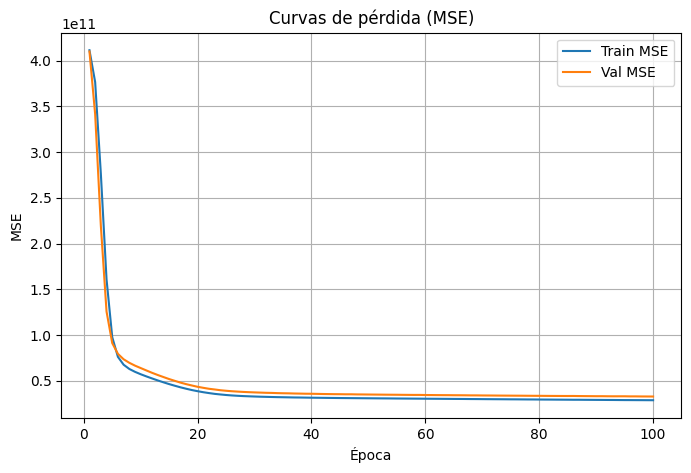

In [13]:

plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), train_losses, label="Train MSE")
plt.plot(range(1, EPOCHS+1), val_losses, label="Val MSE")
plt.xlabel("Época")
plt.ylabel("MSE")
plt.title("Curvas de pérdida (MSE)")
plt.legend()
plt.grid(True)
plt.show()



## 10. Evaluación en el conjunto de prueba


In [14]:

model.eval()
running_test_loss = 0.0
with torch.inference_mode():
    for xb, yb in test_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        preds = model(xb)
        loss = loss_fn(preds, yb)
        running_test_loss += loss.item() * xb.size(0)

test_mse = running_test_loss / len(test_loader.dataset)
print(f"Test MSE final: {test_mse:.2f}")


Test MSE final: 42170952978.87



### Notas prácticas

- Si tu entorno no soporta `num_workers=4`, cámbialo a `0` en la creación de los `DataLoader`.
- Asegúrate de ajustar `DATA_PATH` a la **ruta absoluta** de tu archivo (p.ej., `'/workspace/dataset.csv'` en tu VS Code remoto). En este archivo ya está `'/mnt/data/dataset.csv'` para la ejecución aquí.
- Puedes ajustar el tamaño de las capas, tasa de aprendizaje o `weight_decay` para explorar mejor rendimiento.
